## Demo of Basic GeoPandas Functionality and Application
<div>
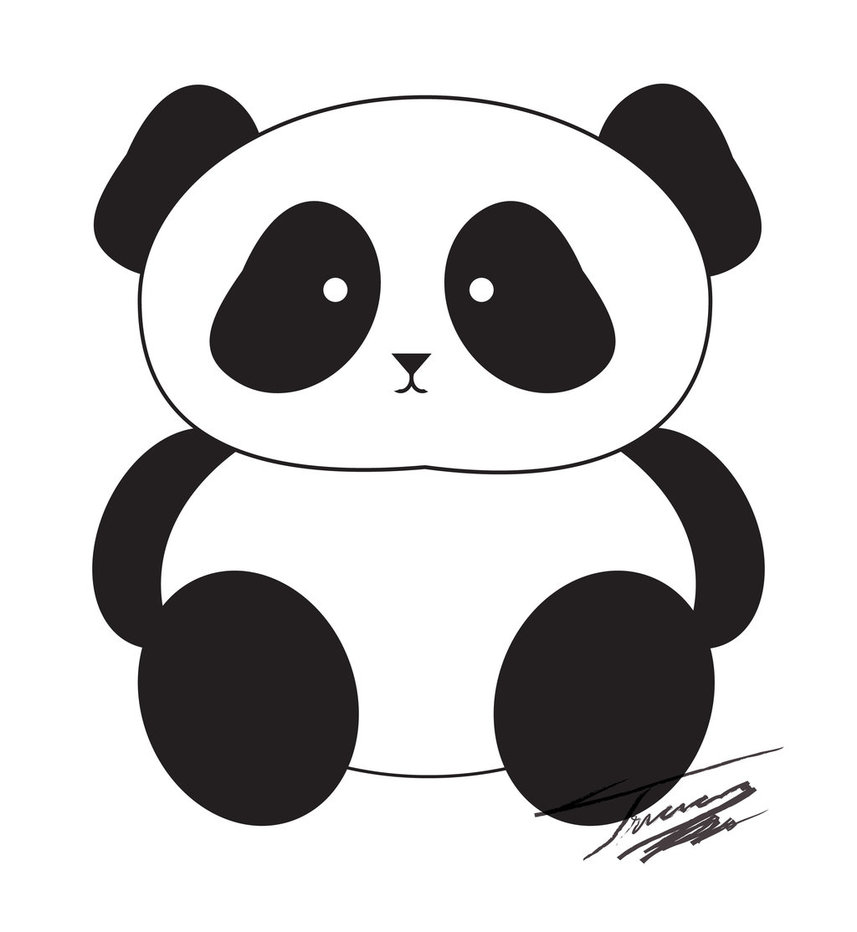
</div>

The GeoPandas library builds off of the common Python library Pandas to incorporate geospatial data. It also draws from some other libraries you may have used before like Shapely and matplotlib for plotting.

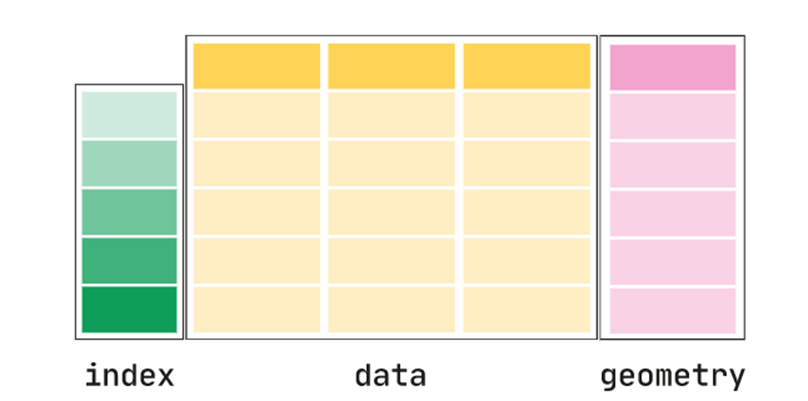


Just a taste of what you can do with GeoPandas:
- read in an plot shape files
- make geometric calculations based on your data - both basic (rotate, scale translate) and more complex (find the distance between points, the location at the center of your polygon etc.)
- maps, maps, maps!
- intersect geospatial data with hazard, economic, health etc. data



### Set Up

Follow instructions here: https://www.geeksforgeeks.org/how-to-install-geopandas-on-windows/ 

Using Anaconda Navigator and conda install is recommended if possible! Also in a completely new environment.

See a basic getting started tutorial here: https://github.com/geopandas/geopandas/blob/main/doc/source/getting_started/introduction.ipynb

#### Import GeoPandas as you would any other package

In [2]:
import geopandas as gpd

In [1]:
import requests
import zipfile
import io
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
%matplotlib notebook

#### Read in your data in the form of shapefiles, geodatabases, GeoJSON

#### Plenty of online databases and APIs exist with geospatial data for you to tap into.
Here I will use the Census's Tiger API which contains shapefiles and geodatabases of US states and territories by state, county, city, tribal area etc. just one of many ways to accomplish this without downloading shapefiles onto your computer.

In [3]:
# pull in the 2020 census data for US counties 
url = 'http://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_500k.zip' 
local_path = 'tmp/'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path=local_path)
filename = [y for y in (z.namelist()) if y.endswith('shp')] 
usa_counties = gpd.read_file(local_path + filename[0])
usa_counties = usa_counties[['STATEFP','COUNTYFP','GEOID','NAME','geometry']]
state_counties = usa_counties[usa_counties.STATEFP == '23']  # cut out only the state of interest

Look at what the shapefile looks like:

In [31]:
state_counties.head()

,STATEFP,COUNTYFP,GEOID,NAME,geometry
51,23,003,23003,Aroostook,"POLYGON ((-70.01975 46.59217, -69.99709 46.695..."
52,23,031,23031,York,"MULTIPOLYGON (((-70.61725 42.99202, -70.61467 ..."
53,23,027,23027,Waldo,"MULTIPOLYGON (((-68.94229 44.28436, -68.94063 ..."
55,23,025,23025,Somerset,"POLYGON ((-70.55279 45.66784, -70.54730 45.666..."
417,23,005,23005,Cumberland,"MULTIPOLYGON (((-69.94153 43.73007, -69.93734 ..."


<IPython.core.display.Javascript object>


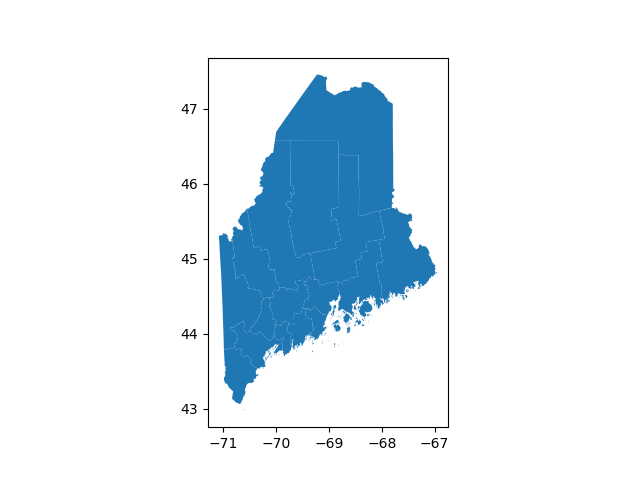

<AxesSubplot:>

In [32]:
state_counties.plot()

### Quick example of a simple computation we could do

In [68]:
# for geometric manipulations, we want the maps to be in distance measures rather than degrees i.e., a projected CRS
state_counties_dist = state_counties.to_crs(epsg=3651)
state_counties_dist.crs

<Projected CRS: EPSG:3651>
Name: NAD83(NSRS2007) / Pennsylvania South
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Pennsylvania - counties of Adams; Allegheny; Armstrong; Beaver; Bedford; Berks; Blair; Bucks; Butler; Cambria; Chester; Cumberland; Dauphin; Delaware; Fayette; Franklin; Fulton; Greene; Huntingdon; Indiana; Juniata; Lancaster; Lawrence; Lebanon; Lehigh; Mifflin; Montgomery; Northampton; Perry; Philadelphia; Schuylkill; Snyder; Somerset; Washington; Westmoreland; York.
- bounds: (-80.53, 39.71, -74.72, 41.18)
Coordinate Operation:
- name: SPCS83 Pennsylvania South zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2007)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich


#### Find the center point of each county and then find the distance from the most southern to the most northern county

In [69]:
state_counties_dist['centroid'] = state_counties_dist.centroid #calculate center
state_counties_dist.head()

,STATEFP,COUNTYFP,GEOID,NAME,geometry,centroid
51,23,003,23003,Aroostook,"POLYGON ((1195126.184 833775.697, 1195855.743 ...",POINT (1303648.060 851546.369)
52,23,031,23031,York,"MULTIPOLYGON (((1181608.222 429908.170, 118180...",POINT (1169412.866 483141.719)
53,23,027,23027,Waldo,"MULTIPOLYGON (((1303456.333 585324.780, 130353...",POINT (1284921.046 607927.626)
55,23,025,23025,Somerset,"POLYGON ((1162589.245 727389.537, 1163033.082 ...",POINT (1210541.608 713853.884)
417,23,005,23005,Cumberland,"MULTIPOLYGON (((1229319.186 516349.251, 122964...",POINT (1191486.514 526096.726)


In [70]:
# get center points of most northern and southern counties
point_1 = state_counties_dist[state_counties_dist.NAME == 'York']['centroid'].iloc[0]
point_2 = state_counties_dist[state_counties_dist.NAME == 'Aroostook']['centroid'].iloc[0]

# calculate the distance between them in km
distance = str(round(point_1.distance(point_2)/1000, 1))

print("Distance between center of York and Aroostook Counties: ", distance, "km")

Distance between center of York and Aroostook Counties:  392.1 km


#### Now lets see what it looks like on a map

<IPython.core.display.Javascript object>


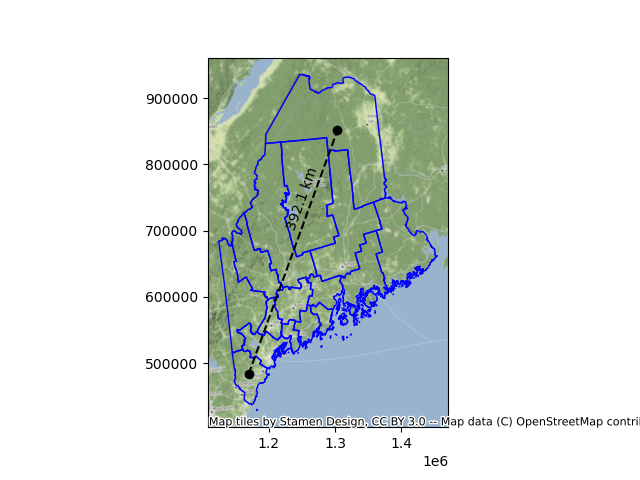

In [65]:
fig, ax = plt.subplots() 

state_counties_dist.plot(facecolor="none",
                   edgecolor="blue", ax=ax)
x_values = [point_1.x, point_2.x]
y_values = [point_1.y, point_2.y]
plt.plot(x_values, y_values, 'ko', linestyle="--")
plt.text(1.24e6, 7e5, "%s km"%distance, fontsize=10, rotation=70, rotation_mode='anchor')
cx.add_basemap(ax, crs=state_counties_dist.crs.to_string())

## Incorporating Economic Data into NOAA Flood Mapping Tools

<big>
Task order for NOAA Office of Coastal Management (OCM) from 2019 to 2021. <br>

We identified a gap in online/publically available flood mapping tools: none existed on the national scale that allowed one to intersect flooding hazards with economic data.<br>

Our ERG team built a Python tool that would allow us to intersect BLS Quarterly Census of Employment and Wages (QCEW) point data with flood hazards from Sea Level Rise 1-10ft, FEMA 100-year and 500-year floodplains, SLOSH Hurricane Storm Surge flooding, and Tsunami Inundation.

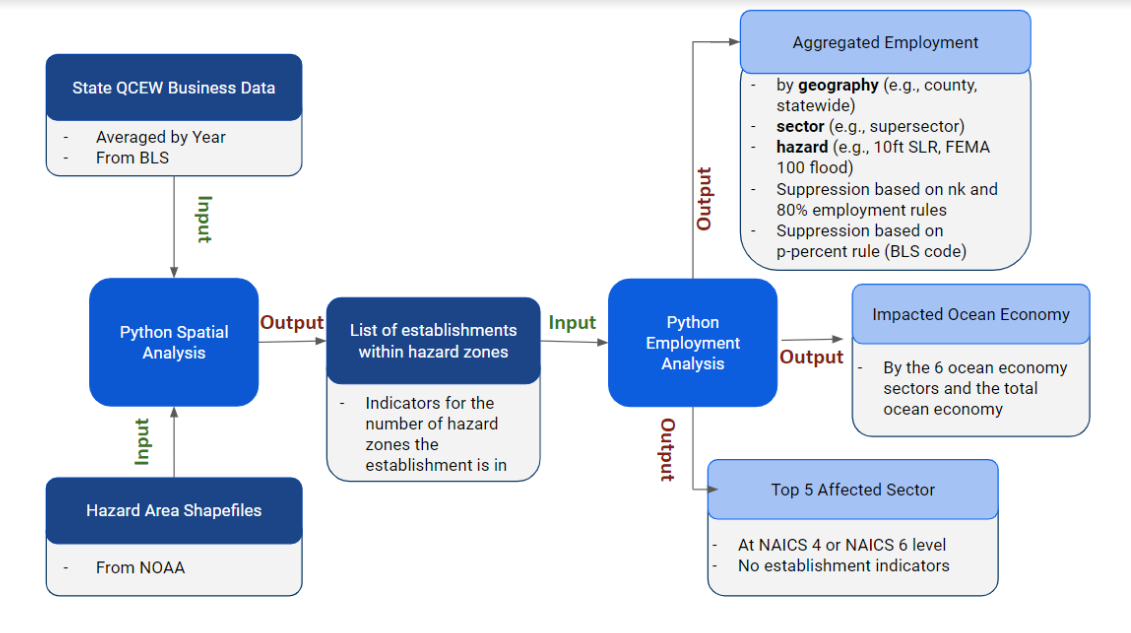

### Example of the intersection between business establishment and flood data

First read in all of the establishments in the state

In [12]:
##read in establishment file 
estab = pd.read_csv("C:/Users/CBerger/Desktop/Projects/NOAA/FloodMapping/FloodPython/FOR NOAA/Flood Econ Impacts/State_QCEW_Data/ME_13_QCEW.csv")

#create new variable in the geodataframe estab with a geometry that is a point using the coordinates in the file
estab_points = gpd.GeoDataFrame(
    estab, geometry=gpd.points_from_xy(estab.long, estab.lat))

estab_points.crs =  "EPSG:4269" #the noaa data uses this CRS so add it to the establishment data

#take just those points from the establishment data
points=estab_points['geometry']
points.head()

0    POINT (-70.20155 44.12474)
1    POINT (-70.39609 44.10527)
2    POINT (-70.11222 44.01816)
3    POINT (-70.22508 44.08891)
4    POINT (-70.21854 44.08643)
Name: geometry, dtype: geometry

Read in the shape file for 2ft of SLR across Maine's coast

In [13]:
start_time = time.time()
bbox=state_counties
state_SLR = gpd.read_file('C:/Users/CBerger/Desktop/Projects/NOAA/FloodMapping/FloodPython/FOR NOAA/Flood Econ Impacts/Hazard_Files/SLR/NOAA_OCM_SLR_Polygons_0620.gdb',layer='Atlantic_merged_slr_2ft',  bbox=bbox, ignore_fields=["Id", "grid_code", "GRIDCODE", "acres"])
print("read in data--- %s seconds ---" % (time.time() - start_time))

read in data--- 78.79837131500244 seconds ---


Plot our outline of Maine with the establishments and SLR shapefile layer

<IPython.core.display.Javascript object>


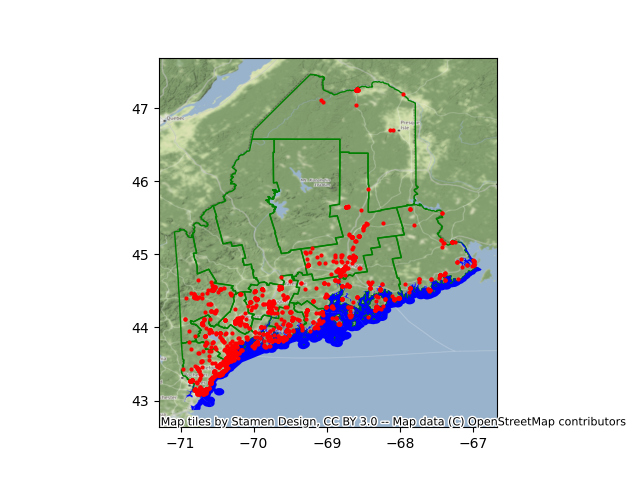

In [75]:
fig, ax = plt.subplots() 

state_counties.plot(facecolor="none",
                  edgecolor="green", ax=ax)
state_SLR.plot(color='blue',ax=ax)
points.plot(color='red',markersize=4,ax=ax)
cx.add_basemap(ax, crs=state_counties.crs.to_string())

### There are multiple ways to intersect these data such as spatial joins and creating masks of your layers. Here we chose to impose a mask of the SLR layer on the the establishment points because a spatial join was more computationally intensive. 

### The SLR layer is so large and detailed that to do this on the state level and have it not take hours, we first split up the shapefile for faster processing, which itself takes a while....

A further explanation of this process as well as a handy shapefile splitting code can be found here: https://snorfalorpagus.net/blog/2016/03/13/splitting-large-polygons-for-faster-intersections/

Maybe a subject for another Data Science talk but I also made use of splitting the code over multiple CPUs on my computer to make the analysis run faster in some cases.

In [71]:
# these are functions that I already created and get pretty in the weeds but follow the general method of splitting up
# the shape file and then overlaying the SLR layer with the employment layer
import katana
from hazardanalysis import splithazard, findpointmatches

In [72]:
SLR_split = splithazard(state_SLR,0.1)

split in chunks--- 697.8690609931946 seconds ---


In [18]:
points_within_geometry = findpointmatches(estab_points, SLR_split)

identify point matches--- 31.73288345336914 seconds ---


#### Now when we plot our points, we only see those establishments that would be vulnerable to 2ft of sea level rise

<IPython.core.display.Javascript object>


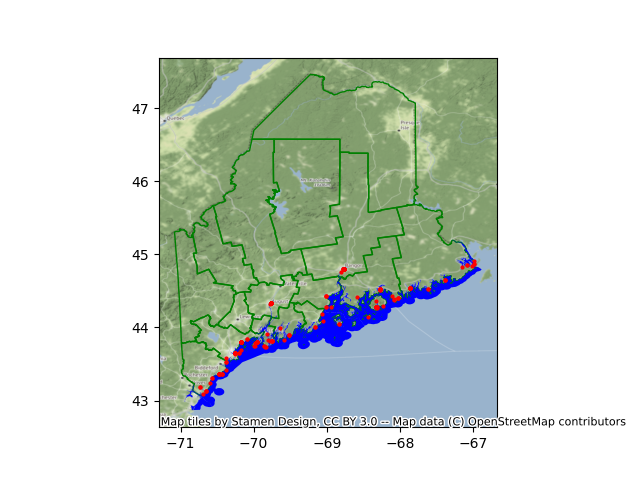

In [76]:
fig, ax = plt.subplots() 

state_counties.plot(facecolor="none",
                  edgecolor="green", ax=ax)
state_SLR.plot(color='blue',ax=ax)
points_within_geometry.plot(color='red',markersize=4,ax=ax)
cx.add_basemap(ax, crs=state_counties.crs.to_string())

### Some outputs have already been published here
https://coast.noaa.gov/digitalcoast/data/coastal-inundation-zones.html

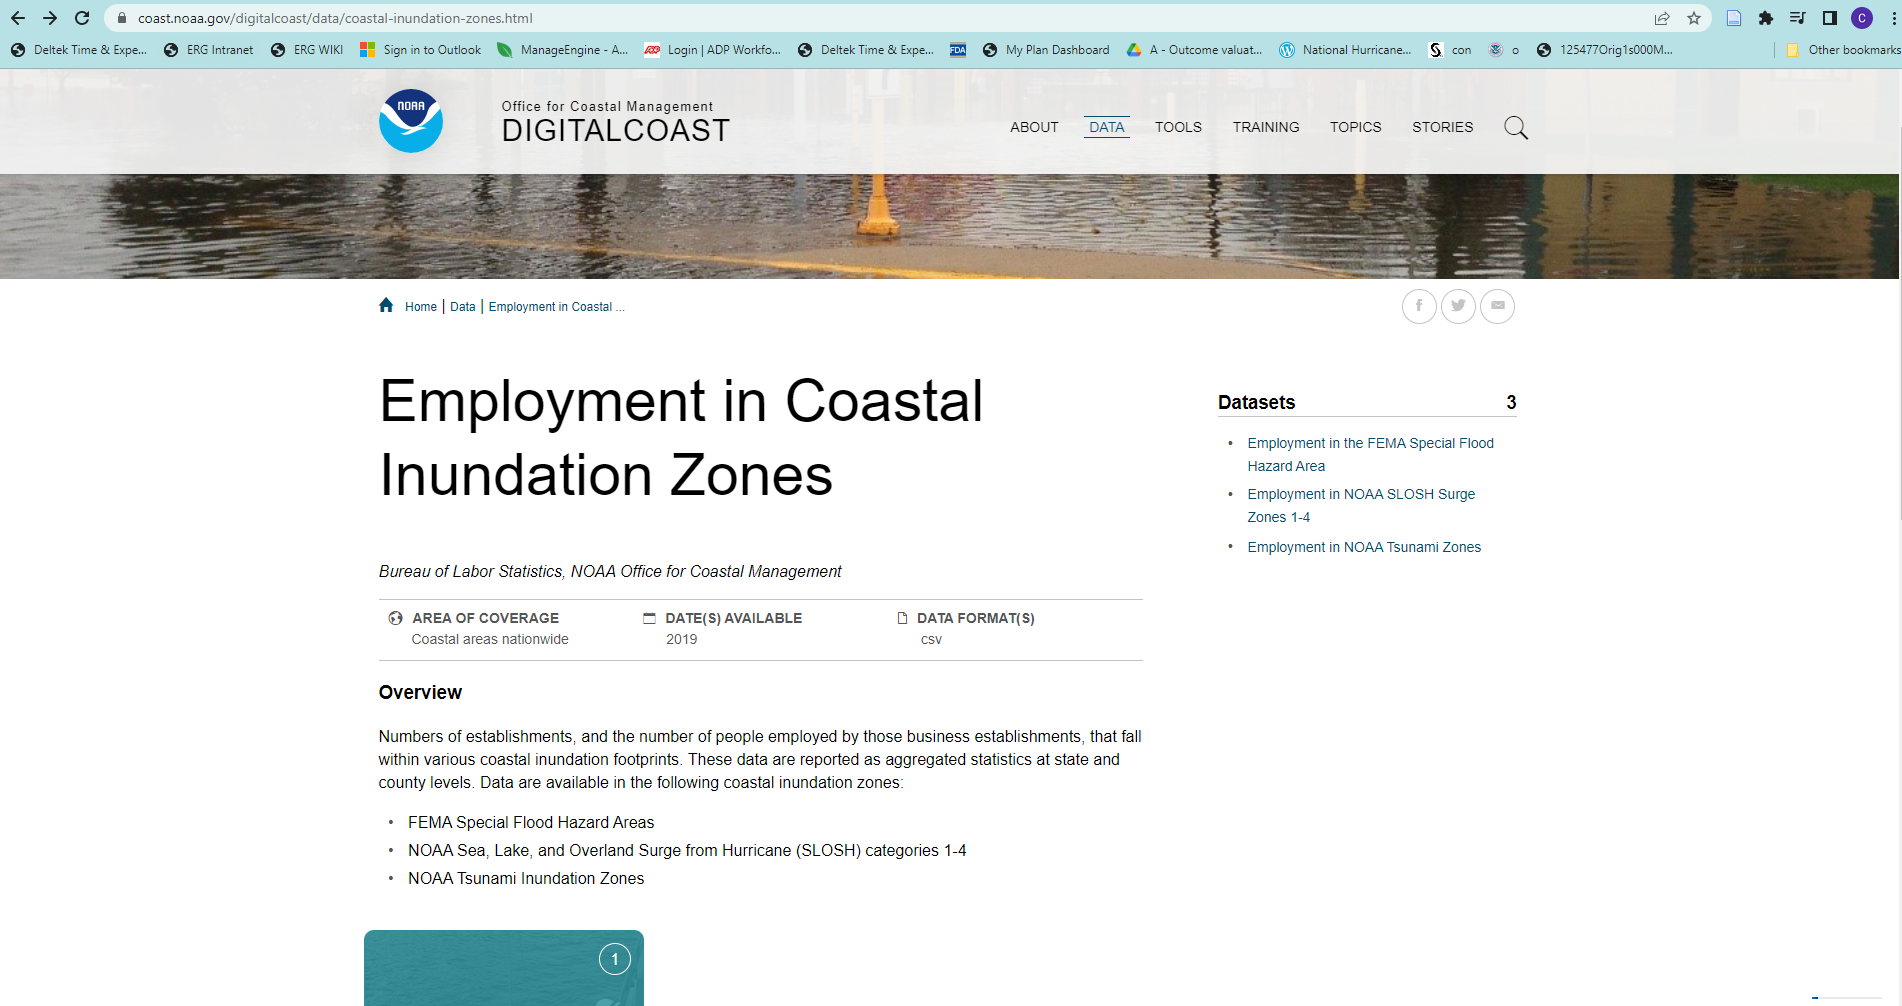

Output Ex: for FEMA flood zone

|GeoID|	StateName|	NAICS2|	SectorName|	Establishments|	Employment|	Flag_Suppression|	Year|	UniqueID|
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
|01000|	Alabama|	00|	Total|	1685|	7044|	|	2019|	0100000 |
|01000|	Alabama|	11|	Agriculture, Forestry, Fishing and Hunting|	30|	93	||	2019|	0100011 |
|01000|	Alabama|	21|	Mining, Quarrying, and Oil and Gas Extraction|	10|	0|	1	|2019|	0100021 |
|01000|	Alabama|	22|	Utilities|	11|	46	||	2019|	0100022 |
|01000|	Alabama|	23|	Construction|	149|	235	||	2019|	0100023 |
|01000|	Alabama|	31-33|	Manufacturing|	106	|1468	||	2019|	0100031 |
|01000|	Alabama|	42|	Wholesale Trade|	101|	245	||	2019	|0100042 |
|01000|	Alabama|	44-45|	Retail Trade|	203	|490	||	2019|	0100044 |
